In [1]:
import torch
import torch.nn as nn
from torch_geometric.nn import VGAE, NNConv
from torch_geometric.utils import dropout_edge
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import numpy as np
import pandas as pd
from pathlib import Path

/home/ensai/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import random

def set_seed(seed=42):
    """Fixe toutes les graines aléatoires pour la reproductibilité"""
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # si multi-GPU
    
    # NumPy
    np.random.seed(seed)
    
    # Python random
    random.seed(seed)    
    print(f"Seed fixée à: {seed}")

# Appeler au début
set_seed(42)

Seed fixée à: 42


In [3]:
def load_graphs(graph_dir):
    # Vérification du dossier
    graph_dir = Path(graph_dir)
    if not graph_dir.exists():
        raise FileNotFoundError(
            f"Le dossier '{graph_dir}' n'existe pas."
        )
    if not graph_dir.is_dir():
        raise NotADirectoryError(
            f"'{graph_dir}' n'est pas un dossier valide."
        )
    graphs = []
    # Charger tous les fichiers .pt
    for file_path in sorted(graph_dir.glob("*.pt")):
        try:
            g = torch.load(file_path)
            graphs.append(g)
            print(f"Graphe chargé : {file_path}")
        except Exception as e:
            print(f"Erreur lors du chargement de {file_path} : {e}")
    return graphs

# Charger les graphes
train_graphs_dir = "graphs/train"
test_graphs_dir = "graphs/test"

train_graphs = load_graphs(train_graphs_dir)
test_graphs = load_graphs(test_graphs_dir)

Graphe chargé : graphs/train/graph_batch_1.pt
Graphe chargé : graphs/train/graph_batch_10.pt
Graphe chargé : graphs/train/graph_batch_11.pt
Graphe chargé : graphs/train/graph_batch_12.pt
Graphe chargé : graphs/train/graph_batch_2.pt
Graphe chargé : graphs/train/graph_batch_3.pt
Graphe chargé : graphs/train/graph_batch_4.pt
Graphe chargé : graphs/train/graph_batch_5.pt
Graphe chargé : graphs/train/graph_batch_6.pt
Graphe chargé : graphs/train/graph_batch_7.pt
Graphe chargé : graphs/train/graph_batch_8.pt
Graphe chargé : graphs/train/graph_batch_9.pt
Graphe chargé : graphs/test/graph_batch_1.pt
Graphe chargé : graphs/test/graph_batch_2.pt
Graphe chargé : graphs/test/graph_batch_3.pt
Graphe chargé : graphs/test/graph_batch_4.pt


/tmp/ipykernel_6348/3133579107.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g = torch.load(file_path)


Graphe chargé : graphs/test/graph_batch_5.pt
Graphe chargé : graphs/test/graph_batch_6.pt
Graphe chargé : graphs/test/graph_batch_7.pt


## Split temporel (train / val)

In [4]:
num_graphs = len(train_graphs)

train_ratio = 0.8

train_end = int(train_ratio * num_graphs)

val_graphs   = train_graphs[train_end:]
train_graphs = train_graphs[:train_end]


# Créer un DataLoader pour l'entraînement
# batch_size = nombre de graphes dans chaque batch
batch_size = 1

train_loader = DataLoader(
    train_graphs,
    batch_size=batch_size,
    shuffle=False
)

val_loader = DataLoader(
    val_graphs,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_graphs,
    batch_size=batch_size,
    shuffle=False
)

## Normalisation des features

In [5]:
# concaténation de tous les noeuds du TRAIN
node_xs = torch.cat([g.x for g in train_graphs], dim=0)
edge_xs = torch.cat([g.edge_attr for g in train_graphs], dim=0)

# Calcul des statistiques pour les nœuds
node_mean = node_xs.mean(dim=0)
node_std  = node_xs.std(dim=0, unbiased=False) + 1e-6

# Calcul des statistiques pour les arêtes
edge_mean = edge_xs.mean(dim=0)
edge_std  = edge_xs.std(dim=0, unbiased=False) + 1e-6

def normalize_graph(g, node_mean, node_std, edge_mean, edge_std):
    g = g.clone()
    g.x = (g.x - node_mean) / node_std
    g.edge_attr = (g.edge_attr - edge_mean) / edge_std
    return g


# Normalisation de tous les graphes
train_graphs = [normalize_graph(g, node_mean, node_std, edge_mean, edge_std) for g in train_graphs]
val_graphs   = [normalize_graph(g, node_mean, node_std, edge_mean, edge_std) for g in val_graphs]
test_graphs  = [normalize_graph(g, node_mean, node_std, edge_mean, edge_std) for g in test_graphs]

## Définir l’encodeur

In [6]:
class NNConvEncoder(nn.Module):
    def __init__(self, in_channels, out_channels, edge_dim, edge_latent_dim, dropout=0.1):
        super(NNConvEncoder, self).__init__()

        self.dropout = dropout

        self.edge_mlp1 = nn.Sequential(
            nn.Linear(edge_dim, edge_latent_dim),
            nn.ReLU(),
            nn.Linear(edge_latent_dim, in_channels * 2 * out_channels),
        )

        self.edge_mlp2 = nn.Sequential(
            nn.Linear(edge_dim, edge_latent_dim),
            nn.ReLU(),
            nn.Linear(edge_latent_dim, 2 * out_channels * 2 * out_channels),
        )

        self.edge_mlp_mu = nn.Sequential(
            nn.Linear(edge_dim, edge_latent_dim),
            nn.ReLU(),
            nn.Linear(edge_latent_dim, 2 * out_channels * out_channels),
        )

        self.edge_mlp_logvar = nn.Sequential(
            nn.Linear(edge_dim, edge_latent_dim),
            nn.ReLU(),
            nn.Linear(edge_latent_dim, 2 * out_channels * out_channels),
        )

        # première couche NNConv
        self.conv1 = NNConv(
            in_channels=in_channels,
            out_channels=2 * out_channels,
            nn=self.edge_mlp1,
            aggr='mean'
        )

        self.conv2 = NNConv(
            in_channels=2 * out_channels,
            out_channels=2 * out_channels,
            nn=self.edge_mlp2,
            aggr='mean'
        )

        # ===== BatchNorm =====
        self.bn1 = nn.BatchNorm1d(2 * out_channels)
        self.bn2 = nn.BatchNorm1d(2 * out_channels)

        # ===== Couches latentes =====
        self.conv_mu = NNConv(
            in_channels=2 * out_channels,
            out_channels=out_channels,
            nn=self.edge_mlp_mu,
            aggr='mean'
        )

        self.conv_logvar = NNConv(
            in_channels=2 * out_channels,
            out_channels=out_channels,
            nn=self.edge_mlp_logvar,
            aggr='mean'
        )

    def forward(self, x, edge_index, edge_attr):
        # ===== Dropout des arêtes =====
        edge_index, edge_mask = dropout_edge(edge_index, p=0.1, training=self.training)
        edge_attr = edge_attr[edge_mask]


        # ===== NNConv 1 =====
        x = self.conv1(x, edge_index, edge_attr)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # ===== NNConv 2 =====
        x = self.conv2(x, edge_index, edge_attr)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # ===== Latent mu / logvar =====
        mu = self.conv_mu(x, edge_index, edge_attr)
        logvar = self.conv_logvar(x, edge_index, edge_attr)

        return mu, logvar
    

## Créer le modèle VGAE

In [7]:
# Dimensions extraites depuis UN graphe (tous ont la même structure)
in_channels = train_graphs[0].x.shape[1]        # features par nœud
out_channels = 16                               # dimension latente
edge_dim = train_graphs[0].edge_attr.shape[1]   # features par arête
edge_latent_dim = 8                             # latent des arêtes

encoder = NNConvEncoder(in_channels, out_channels, edge_dim, edge_latent_dim)
model = VGAE(encoder)

## Définir l’optimiseur

In [8]:
optimizer = torch.optim.AdamW(model.parameters(), lr= 5e-4, weight_decay=1e-4)

## Détecter le device (GPU si dispo)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# device = torch.device('cpu')

# Déplacer le modèle
model = model.to(device)

Using device: cuda


## Early Stopping

In [10]:
patience = 50  # nombre d'époques sans amélioration
best_loss = float('inf')
counter = 0

## Entraînement du modèle

In [11]:
num_epochs = 1000
kl_anneal_epochs = 100  # montée progressive de β


for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0.0

    beta = min(1.0, epoch / kl_anneal_epochs)
    
    # ===== ENTRAÎNEMENT SUR LE PASSÉ =====
    for t, data in enumerate(train_loader):
        assert data.edge_index.dtype == torch.long
        assert data.edge_index.min() >= 0
        assert data.edge_index.max() < data.num_nodes
        # Chaque data = 1 graphe temporel
        data = data.to(device)

        optimizer.zero_grad()
        # Encodage VGAE (NNConv utilise edge_attr)
        z = model.encode(
            data.x,
            data.edge_index,
            data.edge_attr
        )
        # Loss VGAE = reconstruction + KL
        recon_loss = model.recon_loss(z, data.edge_index) / data.num_nodes  # normalisation
        kl_loss = model.kl_loss() / data.num_nodes  # normalisation
        loss = recon_loss + beta * kl_loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # ===== VALIDATION SUR LE FUTUR (SANS BACKPROP) =====
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)

            z = model.encode(
                data.x,
                data.edge_index,
                data.edge_attr
            )

            recon_loss = model.recon_loss(z, data.edge_index) / data.num_nodes  # normalisation
            kl_loss = model.kl_loss() / data.num_nodes

            val_loss += (recon_loss + kl_loss).item()

    print(
        f"Epoch {epoch:03d} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f}"
    )

    # ===== EARLY STOPPING TEMPOREL =====
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_vgae_nnconv.pt")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

Epoch 001 | Train Loss: 23.0894 | Val Loss: 89.0444
Epoch 002 | Train Loss: 34.7843 | Val Loss: 43.0278
Epoch 003 | Train Loss: 39.6408 | Val Loss: 28.1873
Epoch 004 | Train Loss: 53.9113 | Val Loss: 22.3565
Epoch 005 | Train Loss: 48.0474 | Val Loss: 18.0473
Epoch 006 | Train Loss: 43.8737 | Val Loss: 14.5691
Epoch 007 | Train Loss: 39.8299 | Val Loss: 10.6148
Epoch 008 | Train Loss: 26.5020 | Val Loss: 7.2030
Epoch 009 | Train Loss: 35.8643 | Val Loss: 5.4258
Epoch 010 | Train Loss: 23.5922 | Val Loss: 4.1504
Epoch 011 | Train Loss: 18.0802 | Val Loss: 2.9218
Epoch 012 | Train Loss: 18.2293 | Val Loss: 2.6597
Epoch 013 | Train Loss: 13.7789 | Val Loss: 1.5250
Epoch 014 | Train Loss: 12.8615 | Val Loss: 1.1196
Epoch 015 | Train Loss: 9.4501 | Val Loss: 0.6695
Epoch 016 | Train Loss: 9.1215 | Val Loss: 0.3773
Epoch 017 | Train Loss: 7.4142 | Val Loss: 0.3319
Epoch 018 | Train Loss: 7.2979 | Val Loss: 0.2512
Epoch 019 | Train Loss: 4.6317 | Val Loss: 0.2918
Epoch 020 | Train Loss: 4.163

## Charger le modèle

In [12]:
# Charger le meilleur modèle
model.load_state_dict(torch.load("best_vgae_nnconv.pt"))


/tmp/ipykernel_6348/2650110910.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_vgae_nnconv.pt"))


<All keys matched successfully>

## Score de reconstruction

In [13]:
def edge_recon_error(z, edge_index):
    src, dst = edge_index
    logits = (z[src] * z[dst]).sum(dim=1)
    probs = torch.sigmoid(logits)
    error = -torch.log(probs + 1e-9)
    return error  # [num_edges]


## Agrégation vers les NŒUDS

In [14]:
def node_anomaly_score(z, edge_index, num_nodes):
    edge_error = edge_recon_error(z, edge_index)

    src, dst = edge_index
    node_score = torch.zeros(num_nodes, device=z.device)
    node_score.scatter_add_(0, src, edge_error)
    node_score.scatter_add_(0, dst, edge_error)

    degree = torch.zeros(num_nodes, device=z.device)
    degree.scatter_add_(0, src, torch.ones_like(edge_error))
    degree.scatter_add_(0, dst, torch.ones_like(edge_error))

    return node_score / (degree + 1e-6)


## Collecte sur les données de valisation

In [15]:
val_scores = []
val_labels = []

model.eval()
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)

        z = model.encode(
            data.x,
            data.edge_index,
            data.edge_attr
        )

        scores = node_anomaly_score(
            z,
            data.edge_index,
            data.num_nodes
        )

        print("data.y:", data.y)
        print("scores:", scores.shape)

        val_scores.extend(scores.cpu().numpy())
        val_labels.extend(data.y.cpu().numpy())


data.y: tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
scores: torch.Size([30058])
data.y: tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
scores: torch.Size([85848])
data.y: tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
scores: torch.Size([88759])
data.y: tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
scores: torch.Size([69533])
data.y: tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
scores: torch.Size([69348])
data.y: tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
scores: torch.Size([72635])
data.y: tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
scores: torch.Size([139538])


## Choisir un seuil

In [16]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(val_labels, val_scores)

# Exemple : maximiser F1
f1 = 2 * precision * recall / (precision + recall + 1e-9)
best_idx = np.argmax(f1)

best_threshold = thresholds[best_idx]
print("Best threshold:", best_threshold)
print("Precision:", precision[best_idx])
print("Recall:", recall[best_idx])


Best threshold: 1.412085
Precision: 0.0612493239588967
Recall: 0.2111888111888112


In [17]:
threshold = best_threshold
# threshold = np.percentile(val_scores, 99)


## TEST

In [18]:
test_scores = []
test_labels = []
test_preds  = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)

        z = model.encode(
            data.x,
            data.edge_index,
            data.edge_attr
        )

        scores = node_anomaly_score(
            z,
            data.edge_index,
            data.num_nodes
        )

        preds = (scores > threshold).long()

        test_scores.extend(scores.cpu().numpy())
        test_labels.extend(data.y.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())


## Matrice de confusion

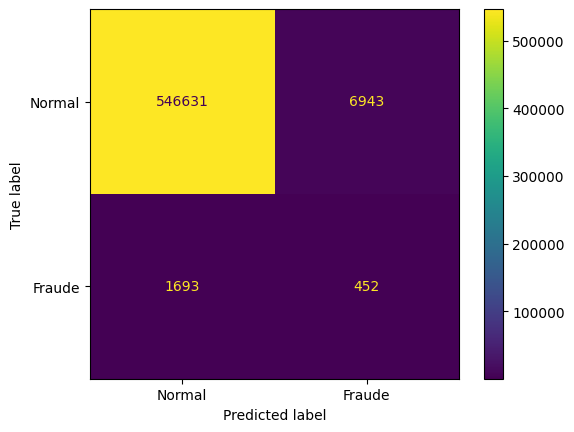

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_labels, test_preds)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Normal", "Fraude"]
)
disp.plot()


## Importance des features

In [20]:
# Importance des features de nœuds
def permutation_importance_node(
    model, data, baseline_scores, feature_idx, device
):
    data_perm = data.clone()
    data_perm.x = data_perm.x.to(device)

    perm = torch.randperm(data_perm.x.size(0))
    data_perm.x[:, feature_idx] = data_perm.x[perm, feature_idx]

    model = model.to(device)
    model.eval()
    
    with torch.no_grad():
        z = model.encode(
            data_perm.x,
            data_perm.edge_index,
            data_perm.edge_attr
        )
        scores = node_anomaly_score(
            z,
            data_perm.edge_index,
            data_perm.num_nodes
        )
    return torch.mean(torch.abs(scores - baseline_scores))

baseline_scores = scores.detach()

importances = []

for k in range(data.x.shape[1]):
    imp = permutation_importance_node(
        model, data, baseline_scores, k, device
    )
    importances.append(imp.item())

importances = np.array(importances)

node_feature_names = [
    # Transaction features
    "amt",
    "hour",
    "dayofweek",
    "is_weekend",
    "age",
    "is_new_merchant",
    "geo_dist",
    "merch_lat",
    "merch_long",
    "category_idx",

    # Card features
    "amt_zscore",
    "card_amt_mean",
    "card_amt_std",
    "gender_idx",
    "job_idx",
    "lat",
    "long",
    "city_pop",

    # Merchant features
    "merchant_avg_amt",
    "merchant_time_since_prev_tx",
]


importance_df = pd.DataFrame({
    "feature": node_feature_names,
    "importance": importances
})

# Tri décroissant
importance_df = importance_df.sort_values(
    by="importance",
    ascending=False
)

pd.set_option("display.float_format", "{:.2e}".format)
print(importance_df)


                        feature  importance
17                     city_pop    4.00e-03
19  merchant_time_since_prev_tx    6.33e-04
10                   amt_zscore    3.01e-04
14                      job_idx    6.55e-06
0                           amt    5.03e-06
6                      geo_dist    2.04e-06
12                 card_amt_std    1.95e-06
18             merchant_avg_amt    8.18e-07
11                card_amt_mean    6.72e-07
8                    merch_long    6.20e-07
16                         long    6.10e-07
4                           age    4.90e-07
1                          hour    2.50e-07
7                     merch_lat    2.14e-07
15                          lat    2.08e-07
9                  category_idx    1.58e-07
2                     dayofweek    9.22e-08
13                   gender_idx    1.82e-08
5               is_new_merchant    1.47e-08
3                    is_weekend    9.03e-09


In [21]:
# Importance des features d’arêtes
def permutation_importance_edge(
    model, data, baseline_scores, feature_idx, device
):
    data_perm = data.clone()
    data_perm.x = data_perm.x.to(device)
    
    perm = torch.randperm(data_perm.edge_attr.size(0))
    data_perm.edge_attr[:, feature_idx] = data_perm.edge_attr[perm, feature_idx]

    model = model.to(device)
    model.eval()

    with torch.no_grad():
        z = model.encode(
            data_perm.x,
            data_perm.edge_index,
            data_perm.edge_attr
        )
        scores = node_anomaly_score(
            z,
            data_perm.edge_index,
            data_perm.num_nodes
        )
    return torch.mean(torch.abs(scores - baseline_scores))

baseline_scores = scores.detach()

edge_importances = []
for k in range(data.edge_attr.shape[1]):
    imp = permutation_importance_edge(
        model, data, baseline_scores, k, device
    )
    edge_importances.append(imp.item())

edge_importances = np.array(edge_importances)

edge_feature_names = [
    "delta_time_log",   # np.log1p(dt)
    "amount_diff",      # |amt_j - amt_i|
    "amount_ratio",     # amt_j / amt_i
    "geo_jump",         # |geo_j - geo_i|
]

edge_importance_df = pd.DataFrame({
    "feature": edge_feature_names,
    "importance": edge_importances
}).sort_values("importance", ascending=False)

print(edge_importance_df)


          feature  importance
1     amount_diff    1.80e-01
3        geo_jump    4.49e-02
2    amount_ratio    2.76e-02
0  delta_time_log    5.92e-03


## Faux positifs / faux négatifs

In [22]:
fp = []
fn = []

offset = 0
for data in test_loader:
    n = data.num_nodes
    labels = np.array(test_labels[offset:offset+n])
    preds  = np.array(test_preds[offset:offset+n])
    scores = np.array(test_scores[offset:offset+n])

    for i in range(n):
        if preds[i] == 1 and labels[i] == 0:
            fp.append((data, i, scores[i]))
        if preds[i] == 0 and labels[i] == 1:
            fn.append((data, i, scores[i]))

    offset += n


In [23]:
data_fp, node_id_fp, score_fp = fp[0]  # exemple : premier FP

# Features du nœud
node_features = data_fp.x[node_id_fp]

# Label réel / prédiction
true_label = data_fp.y[node_id_fp].item()
pred_label = 1  # par définition FP

print("Node ID:", node_id_fp)
print("Score anomalie:", score_fp)
print("Label réel:", true_label)

feature_df = pd.DataFrame({
    "feature name": node_feature_names,
    "feature value": node_features
})

pd.set_option("display.float_format", "{:.3f}".format)

print(print(feature_df.to_string(index=False)))


Node ID: 59
Score anomalie: 1.6474947
Label réel: 0
               feature name  feature value
                        amt         39.600
                       hour         19.000
                  dayofweek          4.000
                 is_weekend          0.000
                        age         41.969
            is_new_merchant          1.000
                   geo_dist         60.908
                  merch_lat         40.080
                 merch_long        -73.038
               category_idx         10.000
                 amt_zscore         -0.433
              card_amt_mean        137.902
               card_amt_std        226.951
                 gender_idx          0.000
                    job_idx        188.000
                        lat         40.829
                       long        -72.647
                   city_pop       3255.000
           merchant_avg_amt         42.954
merchant_time_since_prev_tx       4184.000
None


In [24]:
# Arêtes incidentes au FP
src, dst = data_fp.edge_index
edge_mask = (src == node_id_fp) | (dst == node_id_fp)
edge_ids = edge_mask.nonzero(as_tuple=True)[0]

# Features de ces arêtes (normalisées)
incident_edge_features = data_fp.edge_attr[edge_ids]

# Créer une liste de dictionnaires pour chaque arête
rows = []
for i, eid in enumerate(edge_ids):
    row = {"edge_id": eid.item()}
    for j, fname in enumerate(edge_feature_names):
        row[fname] = incident_edge_features[i, j].item()
    # Ajouter type de connexion : entrante ou sortante
    if src[eid] == node_id_fp:
        row["type"] = "sortante"
    else:
        row["type"] = "entrante"
    rows.append(row)

edge_feature_df = pd.DataFrame(rows)
print(edge_feature_df.to_string(index=False))


 edge_id  delta_time_log  amount_diff  amount_ratio  geo_jump     type
   24457          11.372       28.880         3.694    16.809 entrante
   24458           7.769      732.930        19.508   113.687 sortante


In [25]:
fp_node_id = node_id_fp

neighbor_ids = torch.unique(
    torch.cat([src[edge_ids], dst[edge_ids]])
)

neighbor_ids = neighbor_ids[neighbor_ids != fp_node_id]  # exclure le FP

# Créer une matrice de features : lignes = features, colonnes = nœuds
all_node_ids = [fp_node_id] + neighbor_ids.tolist()

features_matrix = []
for feat_idx in range(data_fp.x.shape[1]):
    row = [data_fp.x[nid, feat_idx].item() for nid in all_node_ids]
    features_matrix.append(row)


# Déterminer le type de connexion (entrante / sortante) pour chaque voisin
direction_dict = {}
for eid in edge_ids:
    if src[eid] == fp_node_id:
        neighbor = dst[eid].item()
        direction_dict[neighbor] = "sortante"
    else:
        neighbor = src[eid].item()
        direction_dict[neighbor] = "entrante"

# Créer un DataFrame
col_names = ["FP"] + [f"{direction_dict[nid]}" for nid in neighbor_ids.tolist()]
row_names = node_feature_names

node_features_df = pd.DataFrame(features_matrix, columns=col_names, index=row_names)

print(node_features_df)

                                  FP  entrante  sortante
amt                           39.600    10.720   772.530
hour                          19.000    18.000    19.000
dayofweek                      4.000     3.000     4.000
is_weekend                     0.000     0.000     0.000
age                           41.969    41.966    41.969
is_new_merchant                1.000     1.000     1.000
geo_dist                      60.908    44.099   174.595
merch_lat                     40.080    40.302    41.650
merch_long                   -73.038   -72.382   -73.054
category_idx                  10.000     7.000    12.000
amt_zscore                    -0.433    -0.584     2.897
card_amt_mean                137.902   146.381   132.119
card_amt_std                 226.951   232.279   221.034
gender_idx                     0.000     0.000     0.000
job_idx                      188.000   188.000   188.000
lat                           40.829    40.829    40.829
long                         -7

In [26]:
data_fn, node_id_fn, score_fn = fn[0]  # exemple : premier FN

# Features du nœud
node_features = data_fn.x[node_id_fn]

# Label réel / prédiction
true_label = data_fn.y[node_id_fn].item()
pred_label = 0  # par définition FN

print("Node ID:", node_id_fn)
print("Score anomalie:", score_fn)
print("Label réel:", true_label)

feature_df = pd.DataFrame({
    "feature name": node_feature_names,
    "feature value": node_features
})

pd.set_option("display.float_format", "{:.3f}".format)

print(print(feature_df.to_string(index=False)))


Node ID: 424
Score anomalie: 0.0
Label réel: 1
               feature name  feature value
                        amt          8.850
                       hour         23.000
                  dayofweek          0.000
                 is_weekend          0.000
                        age         46.623
            is_new_merchant          1.000
                   geo_dist        173.880
                  merch_lat         35.660
                 merch_long        -80.569
               category_idx         13.000
                 amt_zscore         -0.405
              card_amt_mean        116.145
               card_amt_std        264.888
                 gender_idx          0.000
                    job_idx        461.000
                        lat         35.184
                       long        -81.455
                   city_pop       5621.000
           merchant_avg_amt         31.301
merchant_time_since_prev_tx      24215.000
None


In [27]:
# Arêtes incidentes au FN
src, dst = data_fn.edge_index
edge_mask = (src == node_id_fn) | (dst == node_id_fn)
edge_ids = edge_mask.nonzero(as_tuple=True)[0]

# Features de ces arêtes (normalisées)
incident_edge_features = data_fn.edge_attr[edge_ids]

# Créer une liste de dictionnaires pour chaque arête
rows = []
for i, eid in enumerate(edge_ids):
    row = {"edge_id": eid.item()}
    for j, fname in enumerate(edge_feature_names):
        row[fname] = incident_edge_features[i, j].item()
    # Ajouter type de connexion : entrante ou sortante
    if src[eid] == node_id_fn:
        row["type"] = "sortante"
    else:
        row["type"] = "entrante"
    rows.append(row)

edge_feature_df = pd.DataFrame(rows)
print(edge_feature_df.to_string(index=False))


 edge_id  delta_time_log  amount_diff  amount_ratio  geo_jump     type
    5880          11.344     1655.800         0.005    47.436 entrante
    5881           9.208      310.380        36.071    12.656 sortante


In [28]:
fn_node_id = node_id_fn

neighbor_ids = torch.unique(
    torch.cat([src[edge_ids], dst[edge_ids]])
)

neighbor_ids = neighbor_ids[neighbor_ids != fn_node_id]  # exclure le FN

# Créer une matrice de features : lignes = features, colonnes = nœuds
all_node_ids = [fn_node_id] + neighbor_ids.tolist()

features_matrix = []
for feat_idx in range(data_fn.x.shape[1]):
    row = [data_fn.x[nid, feat_idx].item() for nid in all_node_ids]
    features_matrix.append(row)


# Déterminer le type de connexion (entrante / sortante) pour chaque voisin
direction_dict = {}
for eid in edge_ids:
    if src[eid] == fn_node_id:
        neighbor = dst[eid].item()
        direction_dict[neighbor] = "sortante"
    else:
        neighbor = src[eid].item()
        direction_dict[neighbor] = "entrante"

# Créer un DataFrame
col_names = ["FN"] + [f"{direction_dict[nid]}" for nid in neighbor_ids.tolist()]
row_names = node_feature_names

node_features_df = pd.DataFrame(features_matrix, columns=col_names, index=row_names)

print(node_features_df)

                                   FN  sortante  entrante
amt                             8.850   319.230  1664.650
hour                           23.000     2.000    23.000
dayofweek                       0.000     1.000     6.000
is_weekend                      0.000     0.000     1.000
age                            46.623    46.626    46.620
is_new_merchant                 1.000     1.000     1.000
geo_dist                      173.880   161.224   126.444
merch_lat                      35.660    34.211    35.003
merch_long                    -80.569   -80.548   -82.308
category_idx                   13.000     4.000    12.000
amt_zscore                     -0.405     0.784    16.783
card_amt_mean                 116.145   113.590    77.432
card_amt_std                  264.888   262.161    94.571
gender_idx                      0.000     0.000     0.000
job_idx                       461.000   461.000   461.000
lat                            35.184    35.184    35.184
long          